In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torch import optim
from tqdm import tqdm

numpy = lambda x : x.detach().cpu().numpy().squeeze()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import pyrtools as pt
import plenoptic as po

%load_ext autoreload
%autoreload 2

In [2]:
# Preprocessing
# np_img1 = plt.imread('../data/curie.pgm').astype('float')
np_img1 = plt.imread('../data/einstein.png').astype('float')[:,:,0]
# np_img1 = plt.imread('../data/cat7-elephant1.png').astype('float')

# normalize values between 0-1
np_img1 = po.rescale(np_img1)

# if len(np_img1.shape) == 2:                  # if no channel dimension exists
#     np_img1 = np.expand_dims(np_img1, axis=-1)
# np_img1 = np.transpose(np_img1, (2, 0, 1))   # adjust dimensions for pytorch
# np_img1 = np.expand_dims(np_img1, axis=0)    # add batch dimension
# np_img1 = np_img1 / 255.0                    # normalize values between 0-1
# np_img1 = np_img1.astype(np.float32)         # adjust type

# img1 = torch.from_numpy(np_img1)
img1 = torch.tensor(np_img1, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
img2 = torch.rand_like(img1, requires_grad=True).to(device)

img1.requires_grad = False
img2.requires_grad = True

In [3]:
# loss_func = lambda x, y: 1 - po.synth.ssim(x, y)
# loss_func = lambda x, y: 1 - po.synth.msssim(x, y)
# loss_func = po.metric.nlpd
loss_func = po.metric.nspd

value = loss_func(img1, img2)
print("Initial distance: %.5f" % (value.item()))
assert value.requires_grad

Initial distance: 1.41438


In [4]:
optimizer = optim.Adam([img2], lr=0.01, amsgrad=True)

# MSSSIM yields higher values for worse results,
# because noise is removed in scales with lower resolutions

# threshold = 0.5
threshold = 0.001
max_iter = 500

I = []
l = []
i = 0
pbar = tqdm(range(max_iter))
for i in pbar:

    optimizer.zero_grad()
    loss = loss_func(img1, img2)
    value = loss.item()
    pbar.set_postfix(current_distance=f'{value:.2e}')
    loss.backward()
    optimizer.step()
    
    l.append(value)
    
    I.append(numpy(img2).copy())
    if value < threshold:
        break

100%|██████████| 500/500 [03:23<00:00,  2.46it/s, current_distance=1.14e+00]


/home/billbrod/Documents/plenoptic/plenoptic/metric/perceptual_distance.py:94: UserWarning: dynamic_range is 1 but image range falls outside [0, 1] img1: tensor([0., 1.]), img2: tensor([-0.6970,  1.7729]). Continuing anyway...
  warnings.warn("dynamic_range is 1 but image range falls outside [0, 1]"


Difference statistics:
  Range: [-1, 1]
  Mean: -0.097770,  Stdev (rmse): 0.286645,  SNR (dB): -4.883624

 1 - ssim: 0.91368 
 nlpd: 2.76162 
 nspd: 1.14181 



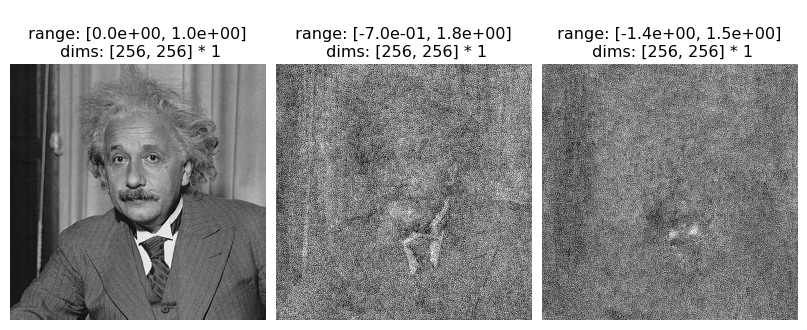

In [5]:
po.imshow([img1, img2, img1 - img2]);
pt.image_compare(numpy(img1), numpy(img2))

print('\n 1 - ssim: %.5f \n nlpd: %.5f \n nspd: %.5f \n' % (
    1 - po.metric.ssim(img1, img2), po.metric.nlpd(img1, img2), po.metric.nspd(img1, img2)))

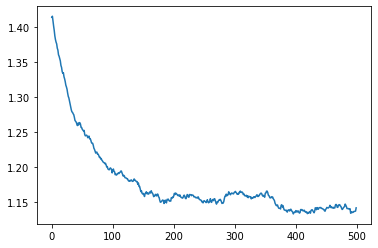

In [6]:
plt.plot(l)

In [7]:
pt.animshow(np.array(I), 25)

In [8]:
# def post_process(img):
#     img = img.detach().cpu().numpy()
#     img = np.transpose(np.squeeze(img, axis=0), (1, 2, 0))
#     img = np.squeeze(img)     # works if grayscale
#     return img

# # Post processing
# img1np = post_process(img1)
# img2 = torch.sigmoid(img2)
# img2np = post_process(img2)

# import matplotlib.pyplot as plt
# cmap = 'gray' if len(img1np.shape) == 2 else None
# plt.subplot(1, 2, 1)
# plt.imshow(img1np, cmap=cmap)
# plt.title('Original')
# plt.subplot(1, 2, 2)
# plt.imshow(img2np, cmap=cmap)
# plt.title('Generated, metric: {:.3f}'.format(value))
# plt.show()